In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap

/home/ericliu/anaconda3/envs/whiskey/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ericliu/anaconda3/envs/whiskey/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Load Dataset

In [3]:
#parameters
batch_size = 128

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=False)

### Define Variational RNN

In [6]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
from torch.nn import Parameter
from torch import linalg as LA

In [15]:
#define auxillary functions
# init weights
def init_weights(layer):
	if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
		init.xavier_normal_(layer.weight)

# exact KL-divergence between twon Gaussians(with known mean and standard deviation)
def kld_guass_exact(mu1, logvar1, mu2, logvar2 ):
	kld = logvar2-logvar1+(logvar1.exp()+(mu1-mu2)**2)/logvar2.exp()-1
	return 0.5*kld.sum(-1)

# NLL loss between a Gaussian and a standard normal distribution
logsqrt2pi=0.5 * np.log(2 * np.pi)
def nll_gauss(mu, log_sigma, x):
	return 0.5 * torch.pow((x - mu) / log_sigma.exp(), 2) + log_sigma + logsqrt2pi


#Soft clip, to allow gradients
def softclip(tensor, min_v):
	result_tensor = min_v + F.softplus(tensor - min_v)
	return result_tensor

# sigma-NLL loss (from sigma VAE)
#keep batch dim
def sigma_nll(x_hat, x):
	log_sigma = ((x - x_hat) ** 2).mean(dim=1,keepdim=True).sqrt().log()
	log_sigma = softclip(log_sigma, -6)
	return nll_gauss(x_hat, log_sigma, x).sum(-1)


In [16]:
class VRNN(nn.Module):
	def __init__(self, input_dim=28, rnn_h_dim=8, rnn_n_layers=2, z_dim=8, rnn_dropout=0.0,  rnn_bias = False, model_type=None):
		super(VRNN, self).__init__()
		self.input_dim=input_dim
		self.rnn_h_dim=rnn_h_dim
		self.rnn_n_layers=rnn_n_layers
		self.z_dim=z_dim
		self.model_type=model_type
		self.rnn_dropout=rnn_dropout
		self.rnn_bias = rnn_bias

		self.rnn_input_dim = self.input_dim
		self.rnn = nn.GRU(self.rnn_input_dim+self.z_dim, self.rnn_h_dim, self.rnn_n_layers, self.rnn_bias, batch_first = True)

		#main task clf
		self.clf = nn.Sequential(
            nn.Linear(self.z_dim, 10),
            nn.LogSoftmax(dim=1)
        )

		#prior based on h(t-1)
		self.prior_mean = nn.Sequential(
			nn.ReLU(),
			nn.Linear(self.rnn_h_dim, self.z_dim)
			)
		self.prior_logvar = nn.Sequential(
			nn.ReLU(),
			nn.Linear(self.rnn_h_dim, self.z_dim)
			)

		#encoder based on x(t) and h(t-1)
		self.enc_mean = nn.Sequential(
			nn.ReLU(),
			nn.Linear(self.input_dim+self.rnn_h_dim, self.rnn_h_dim*2),
			nn.ReLU(),
			nn.Linear(self.rnn_h_dim*2, self.z_dim)
			)
		self.enc_logvar = nn.Sequential(
			nn.ReLU(),
			nn.Linear(self.input_dim+self.rnn_h_dim, self.rnn_h_dim*2),
			nn.ReLU(),
			nn.Linear(self.rnn_h_dim*2, self.z_dim)
			)

		#decoder based on z(t) and h(t-1)
		self.dec_mean = nn.Sequential(
			nn.Linear(self.rnn_h_dim+self.z_dim, self.rnn_h_dim*2),
			#nn.BatchNorm1d(self.rnn_h_dim*2),
			nn.ReLU(),
			nn.Linear(self.rnn_h_dim*2,  self.input_dim)
			)

		#init
		self.clf.apply(init_weights)
		self.prior_mean.apply(init_weights)
		self.prior_logvar.apply(init_weights)
		self.enc_mean.apply(init_weights)
		self.enc_logvar.apply(init_weights)
		self.dec_mean.apply(init_weights)

    #for regularizations
	def get_weights(self):
		w={}
		clf_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.clf) if type(layer)==nn.Linear]
		w['clf_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in clf_weights]))		

		rnn_weights = [LA.matrix_norm(param) for name, param in self.named_parameters() if name.startswith('weight')]
		w['rnn_weights'] = sum(rnn_weights)

		prior_mean_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.prior_mean) if type(layer)==nn.Linear]
		w['prior_mean_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in prior_mean_weights]))
		prior_logvar_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.prior_logvar) if type(layer)==nn.Linear]
		w['prior_logvar_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in prior_logvar_weights]))

		enc_mean_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.enc_mean) if type(layer)==nn.Linear]
		w['enc_mean_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in enc_mean_weights]))
		enc_logvar_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.enc_logvar) if type(layer)==nn.Linear]
		w['enc_logvar_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in enc_logvar_weights]))

		dec_mean_weights = [[s.view(-1) for s in layer.parameters()] for i,layer in enumerate(self.dec_mean) if type(layer)==nn.Linear]
		w['dec_mean_weights'] = torch.sum(torch.Tensor([torch.norm(w[0]) for w in dec_mean_weights]))

		return w


	def weight_sum(self):
		w=self.get_weights()
		return sum([w[k] for k in w.keys()])

    #reparam by given scale and location
	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5*logvar)
		eps = torch.randn_like(std)
		return mu+eps.mul(std)

	#sample size n
	def sample_z(self, n, device):
		sample = torch.randn(n, self.rnn_h_dim+self.z_dim).to(device)
		return self.decode(sample)	


	#input shape: [batch_size, seq_len, input_dim]
	def forward(self, x, is_train=False):
		# vrnn init
		batch_size,max_len = x.shape[0], x.shape[1]
		kld_loss,nll_loss = 0,0
		x_recon,y_pred=[],[]
		zt,logvars,mus=[],[],[]
		h = Variable(torch.zeros(self.rnn_n_layers,batch_size , self.rnn_h_dim)).to(x.device)

		for t in range(max_len):
			#prior
			prior_mean_t=self.prior_mean(h[-1])
			prior_logvar_t=self.prior_logvar(h[-1])

			x_t = x[:,t,:]
			#encoder
			enc_x = torch.cat([x_t, h[-1]], 1)
			enc_mean_t = self.enc_mean(enc_x)
			enc_logvar_t = self.enc_logvar(enc_x)
			logvars.append(enc_logvar_t)
            
			#z, reparameterization
			z_t=self.reparameterize(enc_mean_t, enc_logvar_t)
			zt.append(z_t)
			mus.append(enc_mean_t)
			if is_train:
				y_pred.append(self.clf(z_t))
			else:
				y_pred.append(self.clf(enc_mean_t))
			

			dec_x = torch.cat([z_t, h[-1]], 1)
			dec_mean_t = self.dec_mean(dec_x)
			x_recon.append(dec_mean_t)

			# recurrence
			_, h = self.rnn(torch.cat([x_t, z_t], 1).unsqueeze(1), h)

			kld_t=kld_guass_exact(enc_mean_t, enc_logvar_t, prior_mean_t, prior_logvar_t)
			nll_t=sigma_nll(dec_mean_t, x_t)

			kld_loss+=(kld_t.sum())
			nll_loss+=(nll_t.sum())
		
		res={}
		res['kld_loss']=kld_loss
		res['nll_loss']=nll_loss
		res['y_score']=torch.stack(y_pred).transpose(0,1)
		res['x_recon']=torch.stack(x_recon).transpose(0,1)
		res['logvar']=torch.stack(logvars).transpose(0,1)
		res['z']=torch.stack(zt).transpose(0,1)
		res['mus']=torch.stack(mus).transpose(0,1)
		return res

### Train VRNN

In [17]:
num_epochs = 5
device = torch.device('cpu')
reconcriterion=nn.MSELoss()

def train_RNN(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.squeeze(1)
        data, target = data.to(device), target.to(device)
        N=len(data)*28
        optimizer.zero_grad()
        res_dict = model(data,is_train=True)
        x_recon = res_dict['x_recon']
        loss=F.nll_loss(res_dict['y_score'][:,-1,:], target)
        reconloss=torch.sqrt(reconcriterion(x_recon,data))
        loss += (res_dict['kld_loss']+torch.clamp(res_dict['nll_loss'], min=-10.0, max=10.0))/N + reconloss 

        loss.backward()
        optimizer.step()
        #if batch_idx % 100 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))

def test_RNN(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.squeeze(1)
            data, target = data.to(device), target.to(device)
            res_dict = model(data)
            x_recon = res_dict['x_recon']
            y_pred = res_dict['y_score'][:,-1,:]
            #reconloss=torch.sqrt(reconcriterion(x_recon,data))
            #loss = F.nll_loss(y_pred, target) + (res_dict['kld_loss']+torch.clamp(res_dict['nll_loss'], min=-10.0, max=10.0))/N + reconloss 

            test_loss += F.nll_loss(y_pred, target).item() # sum up batch loss
            pred = res_dict['y_score'][:,-1,:].max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return  correct / len(test_loader.dataset)
    

In [18]:
vmodel=VRNN(input_dim=28, rnn_h_dim=16, rnn_n_layers=2, z_dim=16).to(device)
optimizer = optim.Adam(vmodel.parameters(), lr=0.003)

for epoch in range(1, num_epochs + 1):
    train_RNN(vmodel, device, train_loader, optimizer, epoch)
    acc=test_RNN(vmodel, device, test_loader, epoch)


Epoch: 1 Test set: Average loss: 0.0111, Accuracy: 4107/10000 (41%)

Epoch: 2 Test set: Average loss: 0.0040, Accuracy: 8358/10000 (84%)

Epoch: 3 Test set: Average loss: 0.0022, Accuracy: 9247/10000 (92%)

Epoch: 4 Test set: Average loss: 0.0018, Accuracy: 9395/10000 (94%)

Epoch: 5 Test set: Average loss: 0.0015, Accuracy: 9506/10000 (95%)



### Define Variance SHAP Warpper

In [20]:
vmodel=vmodel.cpu()

#predicted score wrapped model 
class score_wrapper(nn.Module):
    def __init__(self, model):
        super(score_wrapper,self).__init__()
        self.model=model

    def forward(self,x):
        x=x.squeeze(1)
        return self.model(x)['y_score'][:,-1,:]
    
score_wrp= score_wrapper(vmodel)

In [30]:
#varaince wrapped
#varaince approximated by Delta's Method
from torch.autograd import grad,Variable
class variance_wrapper_delta(nn.Module):
    def __init__(self, model):
        super(variance_wrapper_delta,self).__init__()
        self.model=model

    #z: [bs,z_dim]
    #y: [bs,10]
    #out [bs,z_dim, 10]
    def get_derivative(self,z):
        z=Variable(z,requires_grad=True)
        y=self.model.clf(z)
        #y_z=grad(y,z,grad_outputs=torch.ones_like(y),create_graph=True)
        y_z=[grad(y[:,i],z,grad_outputs=torch.ones_like(y[:,i]),create_graph=True)[0] for i in range(10)]
        return (torch.stack(y_z)**2).transpose(0,2).transpose(0,1)
        
    def forward(self,z):
        z1,z2=z[:,:16],z[:,16:]
        y_z=self.get_derivative(z1)
        total_var=torch.bmm(z2.exp().unsqueeze(1),y_z)
        return total_var.squeeze(1)

#Exact form of variance from sum of multiple Gaussains
class variance_wrapper_exact(nn.Module):
    def __init__(self, model):
        super(variance_wrapper_exact,self).__init__()
        self.model=model

    #z: [bs,z_dim]
    #y: [bs,10]
    #out [bs,z_dim, 10]
    def get_derivative(self,z):
        z=Variable(z,requires_grad=True)
        y=self.model.clf(z)
        #y_z=grad(y,z,grad_outputs=torch.ones_like(y),create_graph=True)
        y_z=[grad(y[:,i],z,grad_outputs=torch.ones_like(y[:,i]),create_graph=True)[0] for i in range(10)]
        return (torch.stack(y_z)**2).transpose(0,2).transpose(0,1)
        
    def forward(self,x):
        x=x.squeeze(1)
        res=self.model(x)
        z1,z2=res['mus'][:,-1,:],res['logvar'][:,-1,:]
        y_z=self.get_derivative(z1)
        total_var=torch.bmm(z2.exp().unsqueeze(1),y_z)
        return total_var.squeeze(1)
        
var_wrp= variance_wrapper_exact(vmodel)

### Prediction SHAP, Variance of Prediction SHAP and Varaince SHAP
* SHAP values are computed against conditional expectations, therefore, unlike varaince or SHapley value of varaince, negative varaince SHAP values are not uncommon.

In [43]:
#select background for SHAP computation
train_batch = next(iter(train_loader))
train_images, _ = train_batch
background = train_images[:100]

test_batch = next(iter(test_loader))
images, _ = test_batch
test_images = images[100:101]

* Prediction SHAP

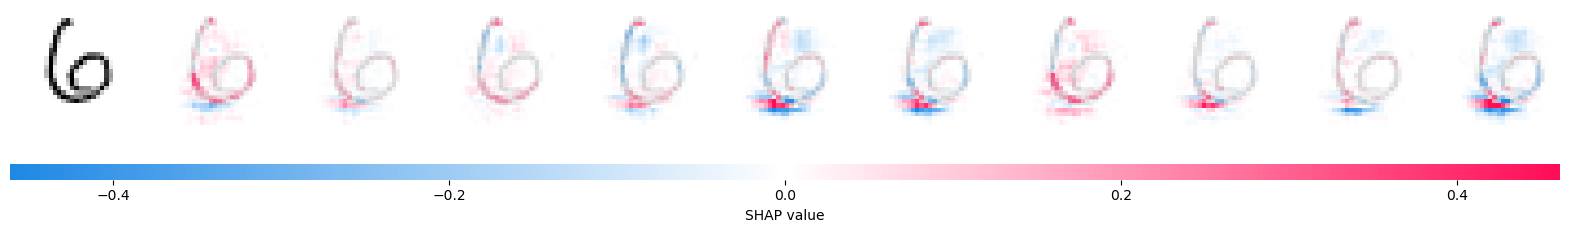

In [45]:
#e = shap.DeepExplainer(score_wrp, background)
e = shap.GradientExplainer(score_wrp, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

* Varaince SHAP

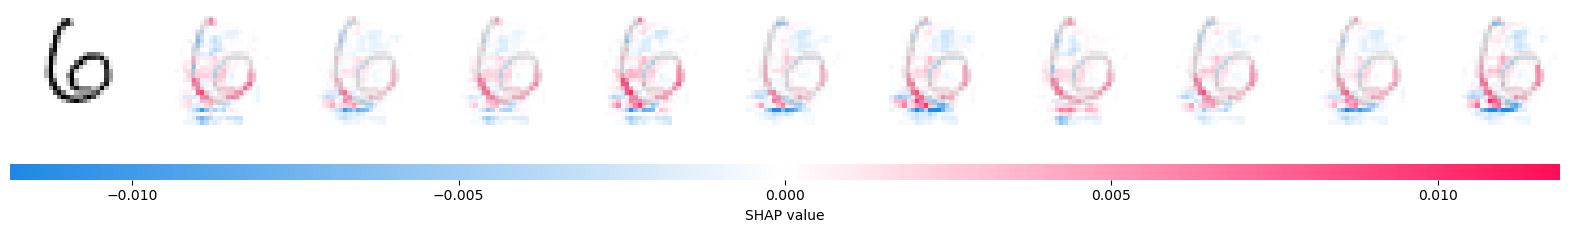

In [46]:
#e = shap.DeepExplainer(var_wrp, background)
e = shap.GradientExplainer(var_wrp, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)